<a href="https://colab.research.google.com/github/AdamMcCloskey381/machine-learning/blob/main/RFC_PNP_bankdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Perceptron

In [5]:
"""loading the dataset"""

df = pd.read_csv(r"/content/bank-full.csv", delimiter = ";")
df = df.replace("unknown", np.nan)
df.isnull().sum()/len(df)

age          0.000000
job          0.006370
marital      0.000000
education    0.041074
default      0.000000
balance      0.000000
housing      0.000000
loan         0.000000
contact      0.287983
day          0.000000
month        0.000000
duration     0.000000
campaign     0.000000
pdays        0.000000
previous     0.000000
poutcome     0.817478
y            0.000000
dtype: float64

In [6]:
"""removing columns 'contact' and 'poutcome' due to high ratio of NaN"""

df = df.drop(columns = ['contact', 'poutcome'])

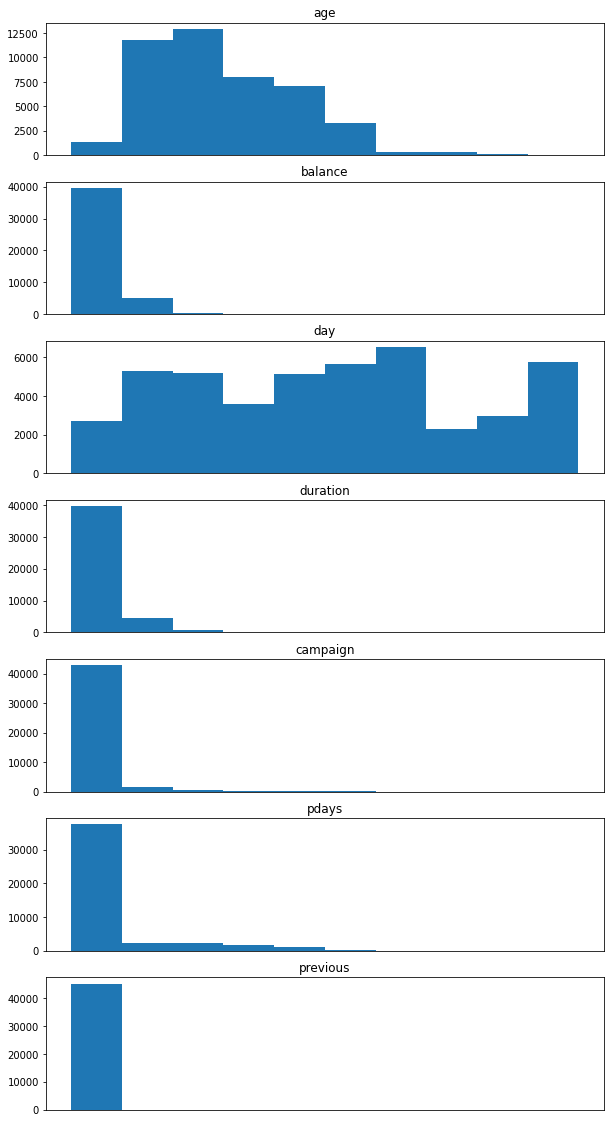

In [7]:
"""analysis of distribution of numerical variables"""

figure, axis = plt.subplots(7, 1)

figure.set_figheight(20)
figure.set_figwidth(10)

df_int = df.select_dtypes(include = "int64")
df_int_columns = df_int.columns.tolist()

for col in df_int_columns:
  axis[df_int_columns.index(col)].hist(df[col])
  axis[df_int_columns.index(col)].set_title(str(col))
  axis[df_int_columns.index(col)].set_xticks([])  

In [8]:
"""closer inspection of distribution of numerical variables"""

for col in ['balance', 'duration', 'campaign', 'pdays', 'previous']:
  print("col name: {}".format(col))
  print(df[col].value_counts())

col name: balance
 0        3514
 1         195
 2         156
 4         139
 3         134
          ... 
-381         1
 4617        1
 20584       1
 4358        1
 16353       1
Name: balance, Length: 7168, dtype: int64
col name: duration
124     188
90      184
89      177
104     175
122     175
       ... 
1833      1
1545      1
1352      1
1342      1
1556      1
Name: duration, Length: 1573, dtype: int64
col name: campaign
1     17544
2     12505
3      5521
4      3522
5      1764
6      1291
7       735
8       540
9       327
10      266
11      201
12      155
13      133
14       93
15       84
16       79
17       69
18       51
19       44
20       43
21       35
22       23
25       22
23       22
24       20
29       16
28       16
26       13
31       12
27       10
32        9
30        8
33        6
34        5
36        4
35        4
43        3
38        3
37        2
50        2
41        2
46        1
58        1
55        1
63        1
51        1
39        

none of the numerical variables were removed

In [9]:
"""data imputation"""

imputer = SimpleImputer(missing_values = np.nan, strategy = "most_frequent")

for col in ['job', 'education']:
  df[[col]] = imputer.fit_transform(df[[col]])

In [10]:
"""checking and modyfing data types within the data frame"""

df_cat = df.select_dtypes(include = "object")

for col in df_int.columns:
  df[col] = df[col].astype("float64")

for col in df_cat.columns:
  df[col] = df[col].astype("category")

In [11]:
"""data scaling"""

scaler = StandardScaler()
for col in df_int.columns:
  df[[col]] = scaler.fit_transform(df[[col]])

In [12]:
"""data encoding"""

df = pd.get_dummies(df, columns = df_cat.columns.tolist(), drop_first = True)

In [13]:
"""splitting the data into x, y and train, test subsets"""

x = df.loc[:, df.columns !="y_yes"]
y = df.loc[:, df.columns == "y_yes"]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.75, random_state = 123)

In [14]:
"""creating and training the RandomForestClassifier model with default hyperparameters"""

rfc = RandomForestClassifier()
y_train = np.ravel(y_train)
rfc.fit(x_train, y_train)

RandomForestClassifier()

In [15]:
"""evaluating the accuracy of the default RandomForestClassifier model"""
score = accuracy_score(y_test, rfc.predict(x_test))
score

0.8994072370167212

In [16]:
"""tuning the hyperparameters of the model using the Grid Search method"""

param_grid=[{"n_estimators": list(range(101))[::10][1:],
             "min_samples_split": list(range(10))[::2][1:]
             }] 

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv = 10, verbose = True, n_jobs = -1)

In [17]:
grid_search.fit(x_train, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'min_samples_split': [2, 4, 6, 8],
                          'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                           100]}],
             verbose=True)

In [18]:
grid_search.best_params_

{'min_samples_split': 6, 'n_estimators': 40}

In [19]:
"""creating and training the RandomForestClassifier model with tuned hyperparameters"""

rfc_tuned = RandomForestClassifier(min_samples_split = grid_search.best_params_["min_samples_split"], 
                                   n_estimators = grid_search.best_params_["n_estimators"]) 
rfc_tuned.fit(x_train, y_train)

RandomForestClassifier(min_samples_split=6, n_estimators=40)

In [36]:
"""evaluating the accuracy of the tuned RandomForestClassifier model"""

score = accuracy_score(y_test, rfc_tuned.predict(x_test))
score

0.900026541626117

In [20]:
"""creating and training the Perceptron model with default hyperparameters"""

pnp = Perceptron()
pnp.fit(x_train, y_train)

Perceptron()

In [22]:
"""evaluating the accuracy of the default Perceptron model"""

score = accuracy_score(y_test, pnp.predict(x_test))
score

0.8771122710784748

In [23]:
param_grid_pnp = [{
    "max_iter": list(range(1001))[::100][1:],
    "penalty": ["l1", "l2"],
    "tol": [1e-2, 1e-3, 1e-4, 1e-5]
}]

In [26]:
grid_search_pnp = GridSearchCV(Perceptron(), param_grid_pnp, cv = 10, verbose = True, n_jobs = -1)

In [30]:
grid_search_pnp.fit(x_train, y_train)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


GridSearchCV(cv=10, estimator=Perceptron(), n_jobs=-1,
             param_grid=[{'max_iter': [100, 200, 300, 400, 500, 600, 700, 800,
                                       900, 1000],
                          'penalty': ['l1', 'l2'],
                          'tol': [0.01, 0.001, 0.0001, 1e-05]}],
             verbose=True)

In [31]:
grid_search_pnp.best_params_

{'max_iter': 100, 'penalty': 'l2', 'tol': 0.001}

In [33]:
"""creating and training the Perceptron model with tuned hyperparameters"""

pnp_tuned = Perceptron(max_iter = grid_search_pnp.best_params_["max_iter"],
                       penalty = grid_search_pnp.best_params_["penalty"],
                       tol=grid_search_pnp.best_params_["tol"])
pnp_tuned.fit(x_train, y_train)

Perceptron(max_iter=100, penalty='l2')

In [34]:
"""evaluating the accuracy of the tuned Perceptron model"""

score = accuracy_score(y_test, pnp_tuned.predict(x_test))
score

0.8878173936123153